## 1. 라이브러리 및 데이터 불러오기

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')




# plt 테마 설정 
plt.style.use(['seaborn-white'])

plt.rc('font', family='AppleGothic')

# 맥 폰트 
plt.rcParams['axes.unicode_minus'] = False


# 데이터셋 분할 & 교차검증 & 하이퍼파라미터 튜닝 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# 결측치 처리
from sklearn.impute import SimpleImputer

# 데이터 전처리 (인코딩, 표준화, 정규화)
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

# 모델링
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# 성능지표 
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

In [2]:
# 학습 데이터 불러오기 
train_data = pd.read_csv('/Users/dongyokim/main/jupyter/2022:2/인공지능/과제 3/train.csv')


# test용 데이터 불러오기
test_data = pd.read_csv('/Users/dongyokim/main/jupyter/2022:2/인공지능/과제 3/test.csv')

# 제출용 데이터 불러오기 
submission_data = pd.read_csv('/Users/dongyokim/main/jupyter/2022:2/인공지능/과제 3/submission_18010244_김동요.csv')

### 1) 변수 소개

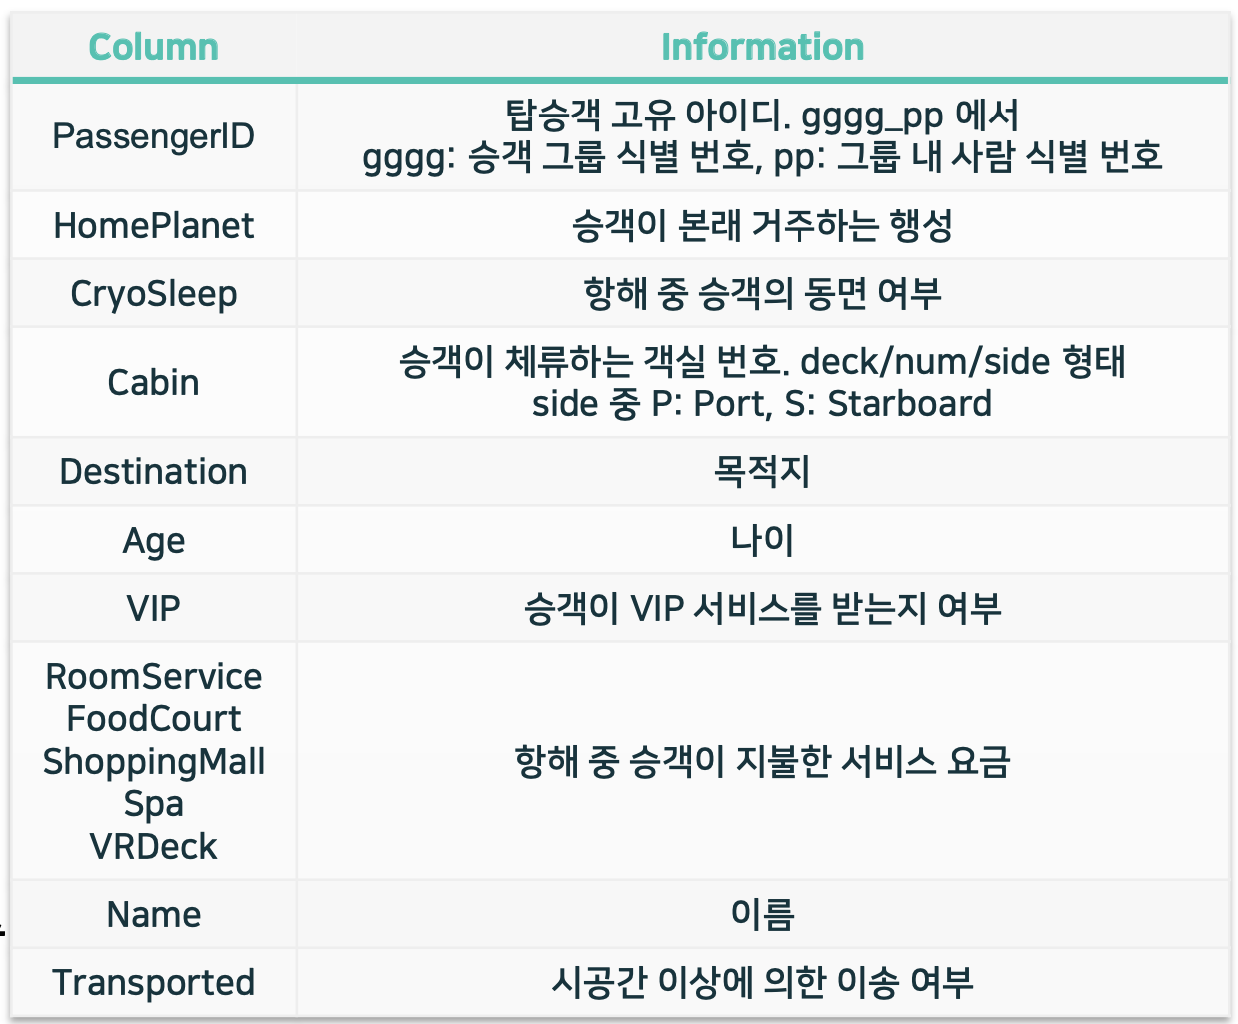

### 2) 데이터 확인

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [28]:
print('train_data shape : {}'.format(train_data.shape))
print('train_data의 결측치 : {}'.format(sum(train_data.isna().sum())))
print('test_data shape : {}'.format(test_data.shape))
print('test_data의 결측치 : {}'.format(sum(test_data.isna().sum())))

train_data shape : (8693, 14)
train_data의 결측치 : 2324
test_data shape : (4277, 13)
test_data의 결측치 : 1117


- train_data는 행이 8693개이며, test_data는 행이 4277개이다. 
- train_data의 결측값들은 총 2324개이며, test_data의 결측값들은 총 1117개이다.

In [7]:
# 변수명 및 변수타입 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


- train_data에는 총 14개의 변수가 존재하며, object type 변수가 7개, float type 변수가 6개, bool type 변수가 1개 존재한다.

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


---
## 2. 결측치 처리 

### 1) 결측치 확인 및 처리

- train_data

In [29]:
# 긱 변수당 결측치의 개수 확인
train_data.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

- 대부분의 변수에 평균 180~200개의 결측 행들이 존재하며, 동면여부(CryoSleep) 변수가 가장 많은 결측값들을 갖고 있다.

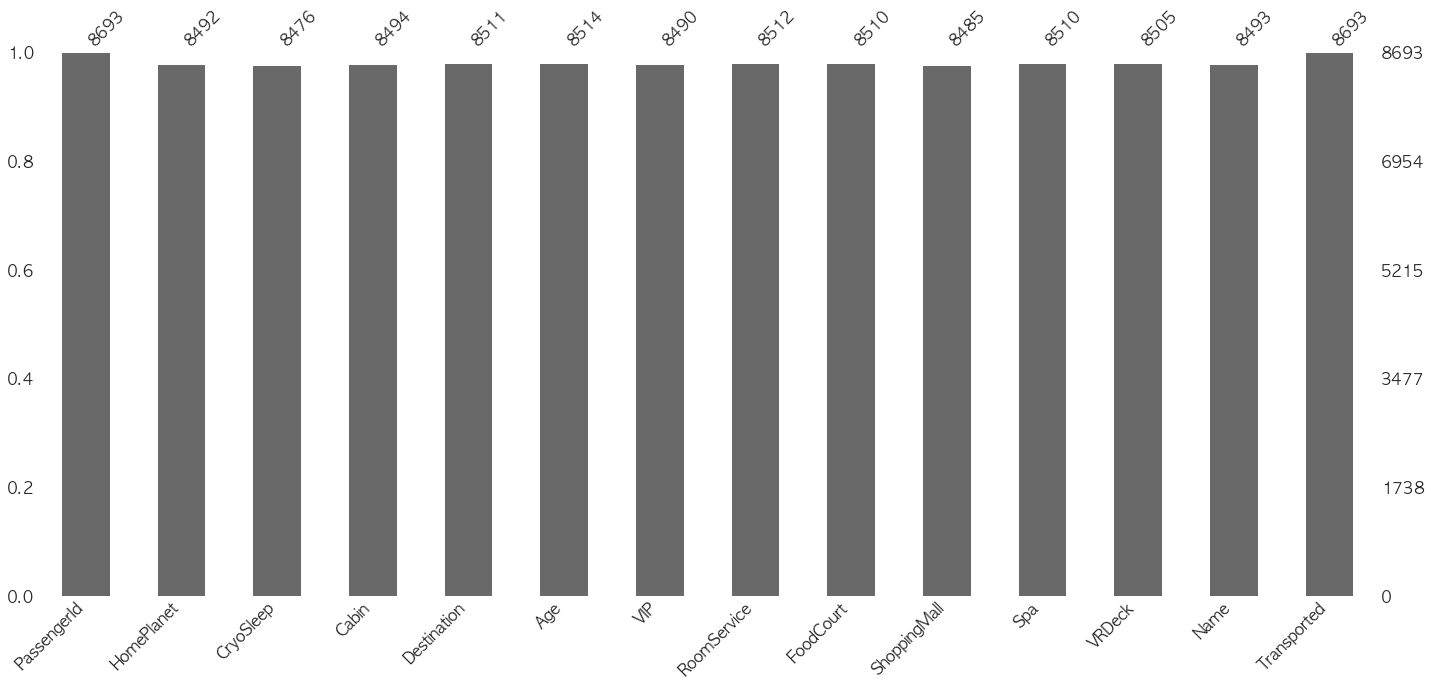

In [10]:
msno.bar(train_data)
plt.show()

In [11]:
# 결측치가 있는 행 추출 
train_data[train_data['HomePlanet'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,True
113,0119_01,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,Batan Coning,False
186,0210_01,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,NaN,0.0,0.0,Arraid Inicont,True
225,0242_01,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,False
234,0251_01,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,True


In [13]:
# 결측치가 있는 행 추출 
train_data[train_data['CryoSleep'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
92,0099_02,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Thewis Connelson,True
98,0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,Carry Cleachrand,False
104,0110_02,Europa,NaN,B/5/P,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.0,Aldeba Bootious,False
111,0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,Rohs Pead,True
152,0173_01,Earth,NaN,E/11/S,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.0,Hilip Grifford,True


In [14]:
# 결측치가 있는 행 추출 
train_data[train_data['Cabin'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False
93,0101_01,Mars,True,NaN,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Book Trad,True
103,0110_01,Europa,False,NaN,TRAPPIST-1e,32.0,False,0.0,410.0,6.0,3929.0,764.0,Graviph Aloubtled,False
222,0239_01,Mars,False,NaN,TRAPPIST-1e,37.0,False,637.0,0.0,0.0,92.0,319.0,Diedow Resty,False
227,0244_01,Mars,True,NaN,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Froos Sad,True


In [16]:
# 결측치가 있는 행 추출 
train_data[train_data['Destination'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
47,0045_02,Mars,True,F/10/P,NaN,19.0,False,0.0,0.0,0.0,0.0,0.0,Mass Chmad,True
128,0138_02,Earth,False,E/5/P,NaN,34.0,False,0.0,22.0,0.0,564.0,207.0,Monah Gambs,False
139,0152_01,Earth,False,F/32/P,NaN,41.0,False,0.0,0.0,0.0,0.0,607.0,Andan Estron,False
347,0382_01,NaN,False,G/64/P,NaN,23.0,False,348.0,0.0,0.0,4.0,368.0,Blanie Floydendley,False
430,0462_01,Earth,True,G/67/S,NaN,50.0,False,0.0,0.0,0.0,0.0,0.0,Ronia Sosanturney,False


In [17]:
# 결측치가 있는 행 추출 
train_data[train_data['Age'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
50,0052_01,Earth,False,G/6/S,TRAPPIST-1e,NaN,False,4.0,0.0,2.0,4683.0,0.0,Elaney Hubbarton,False
64,0068_01,Mars,False,E/4/S,TRAPPIST-1e,NaN,False,793.0,0.0,2.0,253.0,0.0,Cinst Binie,False
137,0149_01,Earth,True,G/27/S,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Billya Hubbarrison,True
181,0202_02,Europa,False,A/2/P,55 Cancri e,NaN,False,0.0,2433.0,NaN,878.0,443.0,Vegas Embleng,True
184,0206_01,Europa,False,C/9/S,55 Cancri e,NaN,False,2.0,1720.0,12.0,1125.0,122.0,Nuson Brugashed,True


In [18]:
# 결측치가 있는 행 추출 
train_data[train_data['VIP'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
38,0036_01,Earth,False,F/8/S,55 Cancri e,15.0,NaN,0.0,492.0,48.0,20.0,401.0,Marina Leodger,False
102,0108_03,Earth,False,G/19/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Oline Handertiz,True
145,0165_01,Mars,True,F/37/P,TRAPPIST-1e,35.0,NaN,0.0,0.0,0.0,0.0,0.0,Graven Anche,True
228,0244_02,Mars,True,F/47/S,55 Cancri e,14.0,NaN,0.0,0.0,0.0,0.0,0.0,Tous Sad,True
566,0593_01,Mars,False,D/24/P,TRAPPIST-1e,NaN,NaN,43.0,152.0,182.0,1.0,2005.0,Hon Kra,False


In [19]:
# 결측치가 있는 행 추출 
train_data[train_data['RoomService'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
25,0020_05,Earth,True,E/0/S,PSO J318.5-22,1.0,False,NaN,0.0,0.0,0.0,0.0,Mael Brantuarez,False
35,0031_03,Mars,False,F/9/P,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,990.0,0.0,Dontch Datie,True
83,0091_01,Earth,True,G/16/S,TRAPPIST-1e,26.0,False,NaN,0.0,0.0,0.0,0.0,Deanne Yorkland,True
132,0141_01,Mars,False,F/30/P,TRAPPIST-1e,31.0,False,NaN,0.0,97.0,0.0,0.0,Pyrohs Harte,False
170,0193_02,Mars,False,F/41/P,TRAPPIST-1e,23.0,False,NaN,0.0,8.0,1072.0,0.0,Frook Raf,False


In [20]:
# 결측치가 있는 행 추출 
train_data[train_data['FoodCourt'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
95,0103_01,Earth,False,F/24/S,TRAPPIST-1e,24.0,False,0.0,NaN,0.0,0.0,17.0,Arlen Mclainez,True
218,0232_01,Earth,True,G/36/S,PSO J318.5-22,27.0,False,0.0,NaN,0.0,0.0,0.0,Nica Bakerrison,False
367,0405_01,Earth,False,F/89/P,55 Cancri e,17.0,False,177.0,NaN,0.0,310.0,7.0,Denis Flowensley,False
385,0427_01,Europa,False,E/26/P,TRAPPIST-1e,31.0,False,417.0,NaN,7185.0,562.0,792.0,Algor Efulows,True
456,0498_01,Europa,True,NaN,55 Cancri e,27.0,False,0.0,NaN,0.0,0.0,0.0,Batomam Preent,True


In [21]:
# 결측치가 있는 행 추출 
train_data[train_data['ShoppingMall'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,False
23,0020_03,Earth,True,E/0/S,55 Cancri e,29.0,False,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,False
28,0024_01,Europa,True,C/2/S,TRAPPIST-1e,62.0,False,0.0,0.0,NaN,0.0,0.0,Penton Fullided,True
40,0039_01,Earth,True,G/1/P,55 Cancri e,30.0,False,0.0,0.0,NaN,0.0,0.0,Jorgie Batthewitt,False


In [22]:
# 결측치가 있는 행 추출 
train_data[train_data['Spa'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
48,0050_01,Earth,False,E/1/S,55 Cancri e,35.0,False,790.0,0.0,0.0,NaN,0.0,Sony Lancis,False
143,0164_01,Earth,False,G/28/S,TRAPPIST-1e,57.0,False,50.0,1688.0,0.0,NaN,135.0,Fany Hutchinton,True
245,0265_01,Europa,True,D/8/S,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,NaN,0.0,Etair Herpumble,True
269,0294_01,Europa,True,B/8/S,TRAPPIST-1e,50.0,False,0.0,0.0,0.0,NaN,0.0,Phonons Roforhauge,True
289,0320_01,Earth,False,G/44/S,TRAPPIST-1e,18.0,False,0.0,2.0,0.0,NaN,0.0,Breney Bellarkerd,False


In [23]:
# 결측치가 있는 행 추출 
train_data[train_data['VRDeck'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
111,0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,Rohs Pead,True
115,0120_01,Mars,True,F/25/P,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,NaN,Bees Sacre,True
251,0278_01,Earth,False,NaN,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,888.0,NaN,Judya Beachez,False
288,0316_02,Europa,True,B/9/S,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,0.0,NaN,Beneba Sorbitter,True


In [24]:
# 결측치가 있는 행 추출 
train_data[train_data['Name'].isnull() == True].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
27,0022_01,Mars,False,D/0/P,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,0.0,0.0,NaN,False
58,0064_01,Mars,True,F/14/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True
65,0069_01,Earth,False,F/16/S,TRAPPIST-1e,42.0,False,887.0,0.0,9.0,6.0,0.0,NaN,True
77,0082_03,Mars,False,F/16/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True
101,0108_02,Earth,False,G/19/S,TRAPPIST-1e,31.0,False,562.0,0.0,326.0,0.0,0.0,NaN,False


In [33]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='mean')
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

In [35]:
# 긱 변수당 결측치의 개수 확인
train_data.isnull().sum().sort_values(ascending=False)

CryoSleep       217
VIP             203
HomePlanet      201
Name            200
Cabin           199
Destination     182
PassengerId       0
Age               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64